## Imports

For Colab users:

In [1]:
# !pip install cartopy

In [2]:
# data handling
import pandas as pd
import numpy  as np
import xarray as xr

# plotting 
import seaborn              as sbn
import matplotlib.pyplot    as pyp
import cartopy.crs          as ccrs
import cartopy.feature      as cfeature
import matplotlib.colors    as mcolors

# modeling
from sklearn.preprocessing      import StandardScaler
from sklearn.linear_model       import LinearRegression
from sklearn.neighbors          import KNeighborsRegressor
from sklearn.ensemble           import RandomForestRegressor
from sklearn.model_selection    import GridSearchCV
from sklearn.metrics            import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection    import cross_val_score

# **Module 4**: Regression Project

Colin Beyers\
GEOL558

# Project Overview

**Title**: Predicting Future SSTs

In this project, I want to test if a Machine Learning (ML) model can predict future Sea Surface Temperature (SST) with environmental indictors. The idea is: if I know the conditions right now, can I predict what SST will be?

There are *many* different mechanisms that force (change) SST.
- Solar radiation: the heat the ocean receives from the Sun is the primary forcing mechanism of SSTs. Due to the tilt of the Earth, solar radiation varies mostly with latitude (and changes seasonally).
- Longwave Radiation: The ocean loses heat to the atmosphere via radiation, which is affected by cloud cover and greenhouse gases.
- Latent Heat Flux: Heat loss due to evaporation, which depends on wind speed, humidity, and SST itself.
- Sensible Heat Flux: Direct heat exchange between the ocean and atmosphere, driven by temperature differences.
- Freshwater Flux: Changing the salinity of water (adding fresh water from precipitation or from rivers) can change it's temperature or how it responds to other forcings.
- Advection (vertical AND horizontal): Movement of warm or cold water by ocean currents.
- Upwelling and Downwelling: Brings cold deep water to the surface (upwelling) or pushes warm surface water downward (downwelling).
- Mixing and Turbulence: Wind-driven mixing redistributes heat within the upper ocean.
- Eddy Trapping: Mesoscale eddies "trap" heat and transports it elsewhere. 
- Bathymetry: Shallow water heats easier than deep water.
- Climate teleconnections: large-scale climate patterns like ENSO have the ability to modulate SSTs through teleconnetions.

Each of these processes modulate SST over different time and spatial scales. The choice of data product and timescales of interest will influence which forcing mechanisms are considered when choosing what features to feed into a ML model.

# Data Selection and Acquisition

For this project, I will use ECMWF (European Centre for Medium-Range Weather Forecasts) Reanalysis v5 (ERA5). This product integrates observations with models to produce hourly-to-daily global gridded data. This model was chosen because of it's integration of real data, ease of access, the volume of variables that are modeled, and it's popularity among researchers. However, all the forcing mechanisms discussed above are not modeled in the ERA5 product. Below, I will justify my decision on what variables in include and which I exclude.

ERA5 data can be easily access with an API call.

**WARNING**: The code below is just an example of how I accessed ERA5 data. There is no need to run the cell.

In [3]:
# import cdsapi

# dataset = "reanalysis-era5-single-levels"
# request = {
#     "product_type": ["reanalysis"],
#     "variable": [
#         "2m_temperature"
#     ],
#     "year": ["2021"],
#     "month": [
#         "01"
#     ],
#     "day": [
#         "01"
#     ],
#     "time": [
#         "00:00"
#     ],
#     "data_format": "netcdf",
#     "download_format": "unarchived"
# }
# 
# client = cdsapi.Client()
# client.retrieve(dataset, request).download()

I collected data for the entire year of 2021 for the following data variables:
- Sea Surface Temperature (SST)
- Net Downward Radiation (NDR): The total radiation from the Sun at the ocean surface; takes into account cloud coverage and other atmospheric processes that could influence surface radiation
- Precipitation (precip)
- Evaporation (evap)
- 2m Temperature (T2m): The temperature at 2 meters above the surface
- 10m Winds (u10/v10): commonly used as the surface wind values

With these variables, the following processes that modulate SST are accounted for:\
✅ Solar radiation: NDR\
✅ Latent Heat Flux: evap and u10/v10\
✅ Sensible Heat Flux: T2m and SST\
✅ Freshwater Flux: precip (*most* freshwater fluxes in the ocean are driven by rain; rivers only matter in coastal regions)\
✅ Upper-ocean Mixing: u10/v10 winds

For this project, what I am really trying to do is predict how much SST will *change* from the current time step to a future time step. The model will know what the SST is at the current time step, so what it needs to be told is what processes primarily drive changes in SST. The following processes are not directly described by the chosen variables, and I give a justification for each as to why I think it's a reasonable decision.\
\
❌ Longwave radiation: compared to solar radiation and heat fluxes, longwave radiation just isn't a primary driver of changes to SST because it happens too slow. It is also possible that given SST(t=0) and SST(t=i) that a ML model might be able to just learn this pattern on it's own.\
❌ Upwelling/Downwelling: This processes is really only significant for coastal regions, where as I am considering all regions of the ocean. It is also a very slow process, varying on seasonal timescales.
❌ Eddy trapping: the rate at which heat is transported via eddy trapping depends in it's translation speed. Eddies translate at a rate of O(1 km) per day. The grid cell size for the ERA5 data product is ~30 km. While eddies may redistribute heat around a grid cell, they are not a driving force in large-scale heat transport.\
❌ Advection: there are many reasons to exclude advection for this project. 
1) Practical considerations: ERA5 does not model ocean currents. Therefore, I would have to collect currents from a different source (AVISO data product, HYCOM ocean model, etc.). Combining this with the ERA5 data would likely require a complicated regridding process. 
2) Ocean currents would also not likely fit well into the `Pandas` `Dataframe` data structure. Ocean currents at one location would advect heat from that location TO another location. For this project, an entry into the final `Dataframe` will be the SST, precip, NDR, etc. at one location in space and time. Providing the currents at that space and time would not actually be informative to predict the SSTs at that same point in the future.
3) Finally, a simple scaling argument can be made to show that currents are not a driving force in distributing heat over short time scales (days). Currents have a speed of O(10 cm/s). Per day, this comes out to O(1 km/day). Again, given the size an ERA5 grid cell (30 km), currents may contribute to changes of SST within the grid cell, but to not contribute to advection of heat from one grid cell to another over short time scales.

❌ Bathymetry: This again is only really relevant for coastal regions, where the depth get's shallow enough to meaningfully modulate how quick the ocean can heat/cool.\
❌ Teleconnections: these are only relevant over seasonal+ timescales.

For this project, I will try to use ML to predict *surface* SSTs over *short time scales* (days).

# Data Preprocessing

Some features had a different temporal resolutions.
- SST: daily resolution
- Everything else: 3-hr resolution (native is 1-hr; I downloaded every 3-hr to save space but also capture daily cycles)

First, all variables needed to have the same daily resolutions. Different variables called for different resampling techniques.
- Extensive variables (`precip`, `evap`): daily sum represents the total amount of flux per day
- Intensive Variables (`NDR`, `u10/v10`, `T2m`): daily average gets rid of daily cycles but captures day-to-day trends

For this project, each row of my `Dataframe` will be the SST, future SSTs (from 1 to 7 days out), and environmental variables (evap, precip, NDR, etc.). he raw global gridded data for the entire year of 2021 was > 10 GB. If this were converted into a `Dataframe` as described above, there would be 100's of millions of entries, which is a bit overkill. Plus, the max file size that can be uploaded to GitHub is 2 GB. So, this dataset needed to be reduced. There are several ways this could have been done:
- Choosing a sample domain, or
- Choosing a sample time frame.
While these methods would have been simple, it's possible that these methods would have led to poor generalization. An interesting goal to pursue for this project would be to tran a ML on a representative subset of ERA5 data and then see if it would be able to predict future SSTs for the entire global domain. Using the subset techniques before would have likely introduced spatial or temporal autocorrelation biases. Instead, I chose to extract 125,000 (about 1% of the size of the original dataset) points in space and time based off of the distribution of SSTs for the entire space and time domain. Then ensures that the `Dataframe` is representative of the entire years worth of data.

**COMMENT**: sorry I didn't have time to put in this figure. If you look at the distribution below though, just imagine the bin on the left being really really tall.

The above distribution has an unusual peak at the lowest bin. There are several reasons this may be:
1) The temperature of this bin, ~ 271 K (-2 C), is just about the coldest seawater can get before freezing. Any values that drop below this would mean the seawater would become ice, and no longer be seawater (and therefore, don't have an SST).
2) These SSTs are likely from grid cells in polar regions. SSTs are known to change less at the poles than they do at the mid-latitudes or tropics, so it may be that throughout time, SSTs in the poles hover around the same value.
3) The model may be performing poor in polar regions because there is less data from these regions to constrain the model 
4) The Gaussian grid used by ERA5 means that grid cells at the poles have a smaller area than those at the mid-latitudes or tropics. This means that there are more or similar amounts of grid cells representing a smaller area, meaning that the SSTs here may be oversampled.

To overcome this, I chose to simply chop the data and only consider between 60 S to 60 N to avoid the dataset being dominated by polar grid cells. This adjusts the distribution to look like the below. Finally, SSTs where chosen from this distribution and were constructed into a `Dataframe` as described above.

In [4]:
url = 'https://raw.githubusercontent.com/colinbeyers/GEOL558-submissions/refs/heads/main/module_4/ERA5-lat%2Clon%2Ctime%2CSST%2Cenv_vars%2CSST(t%2Bi)-2021_small.csv'
df = pd.read_csv(url)

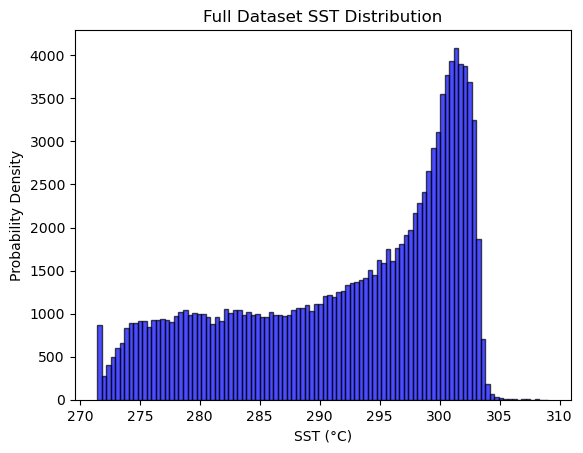

In [5]:
# Plot the histogram of full SST distribution
pyp.hist(df['SST'].values, bins=100, alpha=0.7, color='b', edgecolor='black')
pyp.xlabel("SST (°C)")
pyp.ylabel("Probability Density")
pyp.title("Full Dataset SST Distribution")
pyp.show()

I accidentally summed `NDR` when preprocessing, so I will divide by 8 (8 3-hr time steps per day) to get the mean.

In [6]:
df['NDR'] = df['NDR'] / 8

# Exploratory Data Analysis

While this `Dataframe` no longer contains the spatial and temporal structure of the original gridded dataset, it is a statistical representation of that dataset.

In [7]:
# insert movie here if I have time

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 17 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   time      125000 non-null  object 
 1   lat       125000 non-null  float64
 2   lon       125000 non-null  float64
 3   SST       125000 non-null  float64
 4   NDR       125000 non-null  float64
 5   precip    125000 non-null  float64
 6   evap      125000 non-null  float64
 7   T2m       125000 non-null  float64
 8   u10       125000 non-null  float64
 9   v10       125000 non-null  float64
 10  SST(t+1)  125000 non-null  float64
 11  SST(t+2)  125000 non-null  float64
 12  SST(t+3)  125000 non-null  float64
 13  SST(t+4)  125000 non-null  float64
 14  SST(t+5)  125000 non-null  float64
 15  SST(t+6)  125000 non-null  float64
 16  SST(t+7)  125000 non-null  float64
dtypes: float64(16), object(1)
memory usage: 16.2+ MB


In [9]:
df.describe()

,lat,lon,SST,NDR,precip,evap,T2m,u10,v10,SST(t+1),SST(t+2),SST(t+3),SST(t+4),SST(t+5),SST(t+6),SST(t+7)
count,125000.000000,125000.000000,125000.000000,1.250000e+05,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000
mean,-7.749150,192.894530,292.090542,6.402316e+05,0.001105,-0.001221,290.856538,0.106111,0.152412,292.090869,292.090777,292.090242,292.090520,292.090500,292.090855,292.091106
std,33.624213,97.569726,9.185909,3.039599e+05,0.002532,0.000846,9.063287,6.261268,4.646259,9.185333,9.184172,9.184869,9.185267,9.184883,9.184587,9.184729
min,-60.000000,0.000000,271.458000,2.384000e+03,0.000000,-0.012287,240.272610,-21.129585,-19.432678,271.459230,271.459470,271.337160,271.312740,271.081540,270.919680,270.884280
25%,-37.500000,118.000000,284.665040,3.980780e+05,0.000065,-0.001699,283.875117,-5.114921,-2.943700,284.658450,284.658145,284.644473,284.658637,284.664240,284.663755,284.669560
50%,-10.250000,194.750000,294.776485,6.915040e+05,0.000284,-0.001157,293.418070,-0.699807,0.261457,294.776245,294.766850,294.767215,294.777830,294.766975,294.766600,294.766230
75%,19.000000,271.750000,300.209780,8.890820e+05,0.001009,-0.000613,298.949055,4.772087,3.421205,300.209043,300.212650,300.205382,300.206113,300.206800,300.205080,300.201480
max,60.000000,359.750000,309.042720,1.366688e+06,0.086883,0.002028,311.454160,20.408880,19.444760,308.367430,308.534900,308.812260,308.407230,308.597900,308.523200,308.756600


While the goal  of this data sampling technique was the make the SSTs representative of the SSTs in the original dataset, a good spatial distribution is also important.

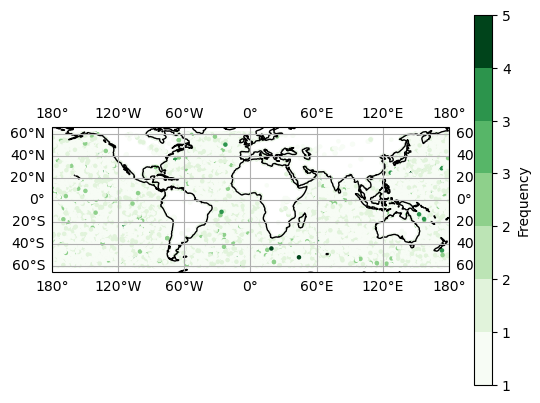

In [10]:
# Count occurrences of each (lon, lat) pair
count = df.groupby(["lon", "lat"])["lon"].transform("count")

# Define discrete bins for frequency values
bins = np.linspace(count.min(), count.max(), num=8)  # Adjust the number of bins if needed
norm = mcolors.BoundaryNorm(bins, ncolors=8)  # 5 discrete colors

# Custom colormap (different shades of purple)
cmap = pyp.get_cmap("Greens", 8)  # "Purples" colormap with 5 discrete levels

# Create figure and axis with PlateCarree projection
fig, ax = pyp.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)

# Scatter plot colored by frequency with discrete colormap
sc = ax.scatter(df["lon"], df["lat"], c=count, cmap=cmap, norm=norm, s=5, transform=ccrs.PlateCarree())

# Add discrete colorbar
cbar = pyp.colorbar(sc, boundaries=bins, ticks=bins, label="Frequency")
cbar.ax.set_yticklabels([f"{int(b)}" for b in bins])  # Format labels as integers

pyp.show()

This data has a good spatial distribution.

## Feature Correlations

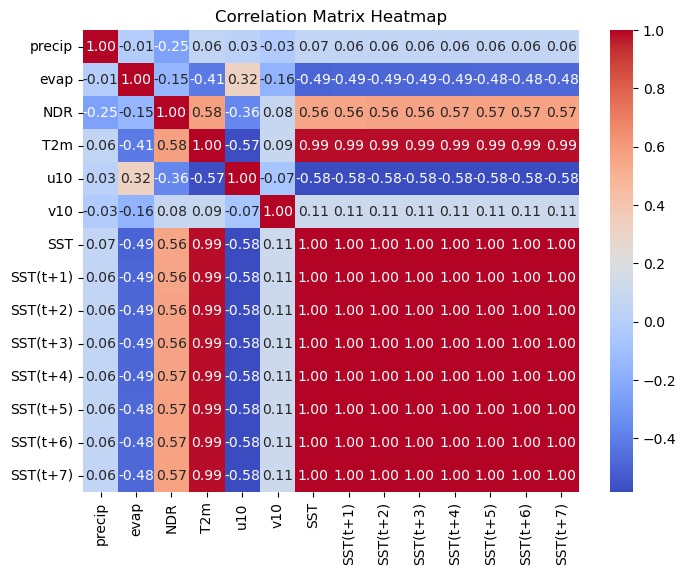

In [11]:
corr_matrix = df[['precip', 
                  'evap', 
                  'NDR',
                  'T2m',
                  'u10',
                  'v10',
                  'SST',
                  'SST(t+1)',
                  'SST(t+2)',
                  'SST(t+3)',
                  'SST(t+4)',
                  'SST(t+5)',
                  'SST(t+6)',
                  'SST(t+7)']].corr()

# Plot the heatmap
pyp.figure(figsize=(8, 6))
sbn.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
pyp.title('Correlation Matrix Heatmap')
pyp.show()

SST one day out from the current timestep (SST(t+1)) is nearly 100% correlated with the SST from the day before. This is not surprising as SST does not change by much day-to-day. It is also highly correlated with the air temperature, and to a lesser degree the NDR. It is negatively correlated with evaporation, meaning that as more water evaporates, SST increases (not surprising - more evaporation usually means it's hotter!). The same is true for u10 - as there is more wind, the ocean responds by cooling. Interestingly, there is very little correlation with v10. This is likely because u-winds (in the x-direction) are winds like the trade winds, which have a much stronger global influence on large-scale ocean dynamics.

## Box and Whisker Plots

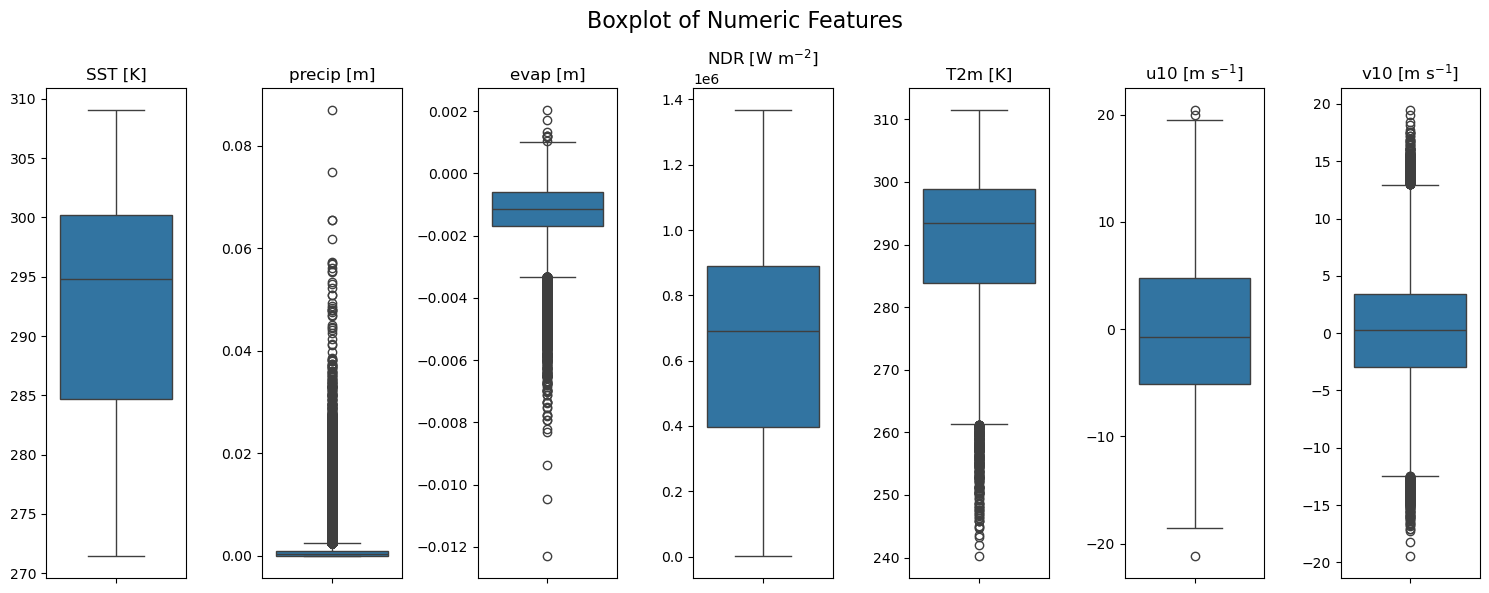

In [12]:
features    = ['SST', 'precip', 'evap', 'NDR', 'T2m', 'u10', 'v10']
units       = ['K', 'm', 'm', 'W m$^{-2}$', 'K', 'm s$^{-1}$', 'm s$^{-1}$']

fig, axes = pyp.subplots(nrows=1, ncols=len(features), figsize=(15, 6))

for ax, feature, unit in zip(axes, features, units):
    sbn.boxplot(data=df[feature], ax=ax)
    ax.set_title(f'{feature} [{unit}]')
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.suptitle('Boxplot of Numeric Features', fontsize=16)

pyp.tight_layout()
pyp.subplots_adjust(top=0.85)

pyp.show()

# Feature Engineering

## Temporal split

To make independent training and testing data, I will use a temporal split. In a "real-world" scenario, I would feed a fully gridded "snapshot" of data to a trained model and have it predict SST at a future timestep. Temporally splitting the data mirrors this approach.

**SIDEBAR**: When I first tried training some models, what I saw (especially from the Random Forests model) was that past SST was the dominant feature for predicting future SST. This makes sense at first, but the other features didn't seem to matter to the model at all. While my R² scores were really high, my MAEs were greater than the mean change in temperature between the past and future state (SST really doesn't change much day-to-day). To avoid inflating the R² and make the MAEs more interpretable, will instead make the target the change in SST between the current and future time step.

In [13]:
df['delta_SST(t+1)'] = df['SST(t+1)'] - df['SST']

In [14]:
df = df.sort_values(by='time')

split_idx = int(0.8 * len(df))  # 80% training, 20% testing

# Split the data into training and testing sets
df_train = df.iloc[:split_idx]
df_test = df.iloc[split_idx:]

# Check the number of points in train and test sets
print(f"Training set size: {df_train.shape}")
print(f"Testing set size: {df_test.shape}")
print(f"Total dataset size: {df.shape}")

Training set size: (100000, 18)
Testing set size: (25000, 18)
Total dataset size: (125000, 18)


## Train/test split

In [16]:
target = ['delta_SST(t+1)']

In [17]:
X_train = df_train[features]
X_test  = df_test[features]
y_train = df_train[target]
y_test  = df_test[target]

## Scale the data

Scaling separately avoids data leakage.

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)

# First Pass

## Linear Regression

Linear regression is a great model to start out on because it's simple and easy to interpret.

In [19]:
model = LinearRegression()

model.fit(X_train, y_train)

y_train_pred    = model.predict(X_train)
y_test_pred     = model.predict(X_test)

The metrics I will calculate are R², RMSE, and MAE (see discussion for more details). I will calculate these metrics for the training and testing sets to see if the model is overfitting.

In [20]:
r2_train    = r2_score(y_train, y_train_pred)
r2_test     = r2_score(y_test, y_test_pred)
rmse_train  = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test   = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_train   = mean_absolute_error(y_train, y_train_pred)
mae_test    = mean_absolute_error(y_test, y_test_pred)

print("Training R²:", r2_train)
print("Testing R²:", r2_test)
print("Training RMSE:", rmse_train)
print("Testing RMSE:", rmse_test)
print("Training MAE:", mae_train)
print("Testing MAE:", mae_test)

Training R²: 0.04528413984557089
Testing R²: 0.05694069566431059
Training RMSE: 0.2141409759395005
Testing RMSE: 0.20405989354773182
Training MAE: 0.1431295664351706
Testing MAE: 0.1421238117188893


Acoss training and testing, the model is performing consistently. However, it is performing consistently bad. The R² close to 0 shows poor fit. To see if the MAE values are reasonable, we can calculate the Mean Absolute Deviation (MAD) of the orginial trainging and testing data.

In [24]:
def mad(arr):
    return np.mean(np.abs(arr - np.mean(arr)))

In [27]:
MAD = mad(df['delta_SST(t+1)'].values)

The MAD is basically the same as the MAE, so the model's errors are not much better than just predicting the mean of the data. This is supported by our R² scores.

In [26]:
train_residuals = y_train.values - y_train_pred
test_residuals = y_test.values - y_test_pred

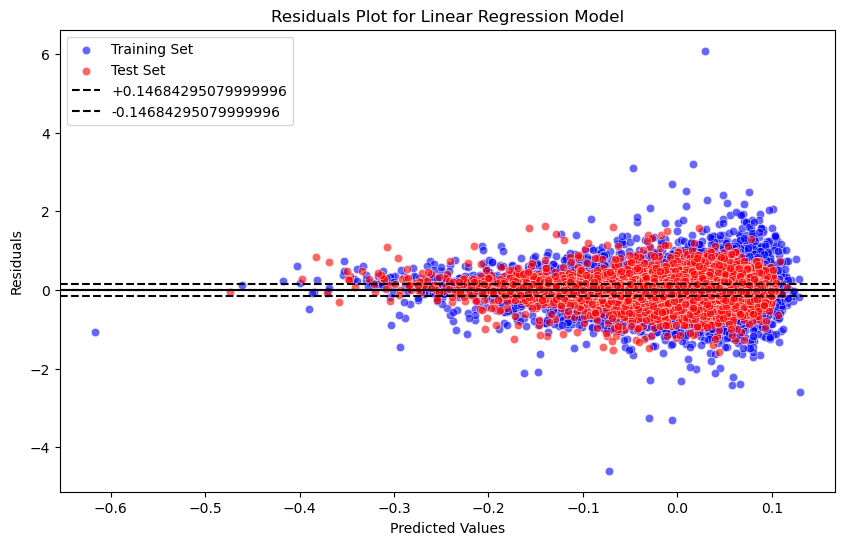

In [29]:
# Plot residuals
pyp.figure(figsize=(10, 6))

# Plot residuals for the training set
sbn.scatterplot(x=y_train_pred.squeeze(), y=train_residuals.squeeze(), color='blue', label='Training Set', alpha=0.6)

# Plot residuals for the test set
sbn.scatterplot(x=y_test_pred.squeeze(), y=test_residuals.squeeze(), color='red', label='Test Set', alpha=0.6)

# Adding labels and title
pyp.axhline(0, color='black')  # Line at y=0
pyp.axhline(MAD, color='black', linestyle='--', label='+0.14684295079999996')  # Horizontal line at +0.14684295079999996
pyp.axhline(-MAD, color='black', linestyle='--', label='-0.14684295079999996')  # Horizontal line at -0.14684295079999996

# Adding labels and title
pyp.axhline(0, color='black', linestyle='--')  # Line at y=0
pyp.xlabel('Predicted Values')
pyp.ylabel('Residuals')
pyp.title('Residuals Plot for Linear Regression Model')
pyp.legend()

# Show the plot
pyp.show()

This residual plot shows that the model is not predicting within an acceptable range to make meaningful predictions of SST. This plot also has some structure---the residuals spread as the predicted change in SST gets more positive. This indicates a systematic bias in the Linear Regression model. Interestingly, the residuals are tighter for the testing data.

# K-Nearest Regressor (KNR)

This model is slightly more complex than linear regression.

In [57]:
# 1. Initialize the KNN regressor
knn = KNeighborsRegressor(n_neighbors=5)

# 2. Fit the model to the training data
knn.fit(X_train, y_train)

# 3. Predict on the training and testing datasets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

In [58]:
# 4. Calculate performance metrics for training and testing
train_r2    = r2_score(y_train, y_train_pred)
test_r2     = r2_score(y_test, y_test_pred)
train_rmse  = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse   = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae   = mean_absolute_error(y_train, y_train_pred)
test_mae    = mean_absolute_error(y_test, y_test_pred)

# 5. Print the results
print(f"Training R²:   {train_r2}")
print(f"Testing R²:   {test_r2}")
print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE:  {test_rmse}")
print(f"Training MAE:  {train_mae}")
print(f"Testing MAE:   {test_mae}")

Training R²:   0.27848719161016566
Testing R²:   -0.11173238077442083
Training RMSE: 0.18615929755862853
Testing RMSE:  0.2215584311647941
Training MAE:  0.12839573771999993
Testing MAE:   0.15847697488000026


Unfortunately, a negative R² indicates that the model is performing worse than a simple baseline model (such as predicting the mean of the target variable for all data points). There is also a much greater disrepancy between the training and testing metrics, indicating overperformance.

In [59]:
train_residuals = y_train.values - y_train_pred
test_residuals = y_test.values - y_test_pred

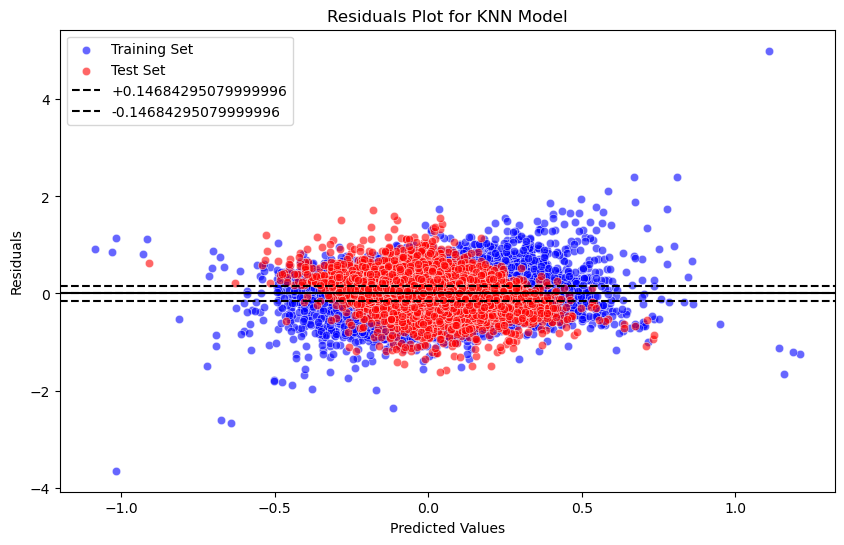

In [60]:
# Plot residuals
pyp.figure(figsize=(10, 6))

# Plot residuals for the training set
sbn.scatterplot(x=y_train_pred.squeeze(), y=train_residuals.squeeze(), color='blue', label='Training Set', alpha=0.6)

# Plot residuals for the test set
sbn.scatterplot(x=y_test_pred.squeeze(), y=test_residuals.squeeze(), color='red', label='Test Set', alpha=0.6)

# Adding labels and title
pyp.axhline(0, color='black')  # Line at y=0
pyp.axhline(MAD, color='black', linestyle='--', label='+0.14684295079999996')  # Horizontal line at +0.14684295079999996
pyp.axhline(-MAD, color='black', linestyle='--', label='-0.14684295079999996')  # Horizontal line at -0.14684295079999996

# Adding labels and title
pyp.axhline(0, color='black', linestyle='--')  # Line at y=0
pyp.xlabel('Predicted Values')
pyp.ylabel('Residuals')
pyp.title('Residuals Plot for KNN Model')
pyp.legend()

# Show the plot
pyp.show()

The residual plot here shows a systematic bias in the training set (there is a linear increase). We could investigate this bias futher, but the residuals show poor model skill either way. It is likely that simply the structure of a KNN model is not appropriate for this dataset.

## Random Forests

Random Forests is a big step up from both the previous models. 

**WARNING**: This cell takes a few minutes to run.

**SIDEBAR**: On my lab groups server, I ran a grid search to find the best parameters. This cell look a very long time to run despite the computing power I used, so for this RF model I'm just going to use the best parameters that I found.

In [62]:
# 3. Random Forest Model
rf = RandomForestRegressor(max_depth= 10, 
                           min_samples_leaf = 4, 
                           min_samples_split = 10, 
                           n_estimators = 200)

# Train the model
rf.fit(X_train, y_train)

# Predictions on training data
y_train_pred = rf.predict(X_train)

# Predictions on test data
y_test_pred = rf.predict(X_test)

/home/colin_beyers/miniconda3/envs/parcels_working/lib/python3.12/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [65]:
# Calculate R², RMSE, and MAE for training and testing data
train_r2    = r2_score(y_train, y_train_pred)
test_r2     = r2_score(y_test, y_test_pred)
train_rmse  = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse   = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae   = mean_absolute_error(y_train, y_train_pred)
test_mae    = mean_absolute_error(y_test, y_test_pred)

# Print evaluation metrics
print(f"Training R²: {train_r2}")
print(f"Testing R²: {test_r2}")
print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Testing MAE: {test_mae}")

Training R²: 0.15180546445769505
Testing R²: 0.06591158937601482
Training RMSE: 0.2018414902677016
Testing RMSE: 0.20308700994831677
Training MAE: 0.1364501994663146
Testing MAE: 0.14135114388126635


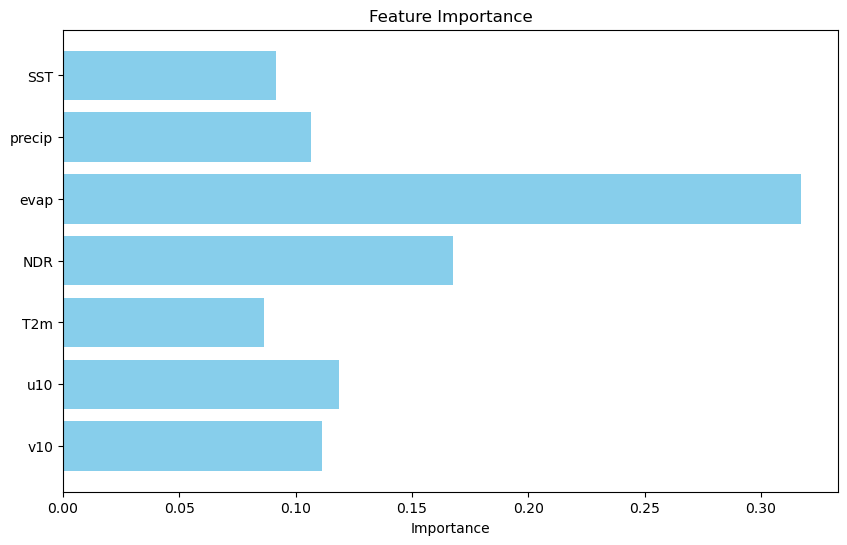

In [66]:
importances = rf.feature_importances_
# Assuming `features` is a list of feature names and `importances` contains the feature importances
# Plotting the feature importances
pyp.figure(figsize=(10, 6))
pyp.barh(features, importances, color='skyblue')
pyp.xlabel('Importance')
pyp.title('Feature Importance')
pyp.gca().invert_yaxis()  # Optional: Inverts the y-axis to have the highest importance at the top
pyp.show()

The RF model feature importances shows that evaporation was the most important feature to the model. This is likely misleading---something like winds, radiation, or 2m temperature should likely be the more important. The past SST is very unimportant to the model. While we are trying to predict the change in SST, without the context of how SST changed over time (say, for the last week), the feature is honestly quite useless on its own. Really, it would only help indicate change a little bit, as warmer parts of the ocean tend to change tempature quicker than colder parts.

In [71]:
train_residuals = y_train.values.squeeze() - y_train_pred
test_residuals = y_test.values.squeeze() - y_test_pred

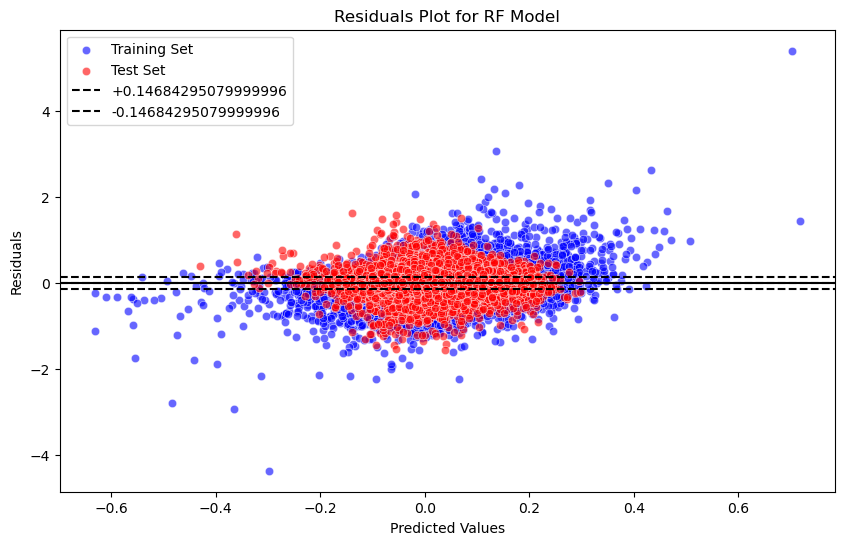

In [72]:
# Plot residuals
pyp.figure(figsize=(10, 6))

# Plot residuals for the training set
sbn.scatterplot(x=y_train_pred.squeeze(), y=train_residuals.squeeze(), color='blue', label='Training Set', alpha=0.6)

# Plot residuals for the test set
sbn.scatterplot(x=y_test_pred.squeeze(), y=test_residuals.squeeze(), color='red', label='Test Set', alpha=0.6)

# Adding labels and title
pyp.axhline(0, color='black')  # Line at y=0
pyp.axhline(MAD, color='black', linestyle='--', label='+0.14684295079999996')  # Horizontal line at +0.14684295079999996
pyp.axhline(-MAD, color='black', linestyle='--', label='-0.14684295079999996')  # Horizontal line at -0.14684295079999996

# Adding labels and title
pyp.axhline(0, color='black', linestyle='--')  # Line at y=0
pyp.xlabel('Predicted Values')
pyp.ylabel('Residuals')
pyp.title('Residuals Plot for RF Model')
pyp.legend()

# Show the plot
pyp.show()

This residual plot shows a lot of similarities to the KNN model.

## Performance Accross Models

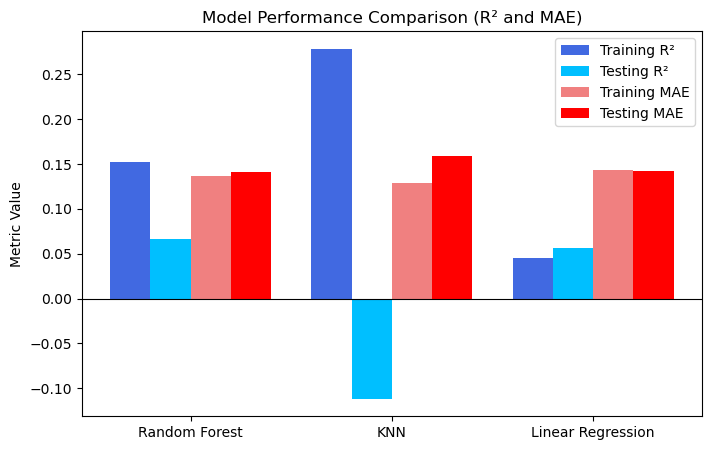

In [75]:
# Model names
models = ["Random Forest", "KNN", "Linear Regression"]

# R² scores
r2_train = [0.1518, 0.2785, 0.0453]
r2_test = [0.0659, -0.1117, 0.0569]

# MAE scores
mae_train = [0.1365, 0.1284, 0.1431]
mae_test = [0.1414, 0.1585, 0.1421]

# Bar width and x locations
x = np.arange(len(models))
width = 0.2  

fig, ax = pyp.subplots(figsize=(8, 5))

# Plot R² scores
ax.bar(x - width, r2_train, width, label="Training R²", color="royalblue")
ax.bar(x, r2_test, width, label="Testing R²", color="deepskyblue")

# Plot MAE scores
ax.bar(x + width, mae_train, width, label="Training MAE", color="lightcoral")
ax.bar(x + 2 * width, mae_test, width, label="Testing MAE", color="red")

# Labels and formatting
ax.set_xticks(x + width / 2)
ax.set_xticklabels(models)
ax.axhline(0, color="black", linewidth=0.8)  # Baseline at y=0
ax.set_ylabel("Metric Value")
ax.set_title("Model Performance Comparison (R² and MAE)")
ax.legend()
pyp.show()

Despite increasing model complexity, all training and testing MAE stayed at similar values. This supports that the models I chose are simply not appropriate for this problem, or there is an underlying problem with the way I constructed my dataframe from the orginal gridded dataset (likely both).

# Discussion

*1. Which method did you like the most?*

While no base model performed well (like, at all), the Random Forests (RF) model shows the most promise for hyperparameter tuning. This is definitely a complicated problem! I think an RF model is really the only choice that I tried so far that has enough tuning options to get a working model spun up. However, I think the real problem is that I'm not using a Neural Network (NN) approach. A NN are far better equipped to take structured gridded data (like my original dataset) and making predictions. In literature that has tackled similar problems, they have all used NN. NN can also take into account time lags by taking past information at a certain location to predict a future condition. Simply put, the structure and design of NN models is way better suited for this problem.

*2. Which method did you like the least?*


I liked KNR the least. While it ran quickly, it's R² scores were really bad. Even though this model was not tuned, baseline models can still usually show how appropriate they are for the problem. A model that is struggling to make any meaningful predictions is likely not one worth investing more time into.

*3. How did you score these supervised models?*

For each model, I used the following metrics. I calculated them for the training and testing sets of data, to assess if the model was generalizing well or not.

**R² (Coefficient of Determination)**: The proportion of the variance in the target variable that is explained by the model. It's range is from 0 to 1 (higher is better). A higher R² indicates a better fit of the model to the data, but it may be misleading if the model is overfitting.

**RMSE (Root Mean Squared Error)**: The square root of the average squared differences between predicted and actual values. It's range is from 0 to ∞ (lower is better). RMSE gives an idea of the magnitude of error in the model’s predictions. It is more sensitive to larger errors because it squares the residuals.

**MAE (Mean Absolute Error)**: The average of the absolute differences between predicted and actual values. It's range is from 0 to ∞ (lower is better). MAE provides an average size of errors, making it easier to interpret. Unlike RMSE, it does not penalize large errors as much. It's units are the same as the target, which makes it very interpretable, especially if you're familiar with your data.

*4. Did the output align with your geologic (oceanographic) understanding?*

After exploring this problem more, the results do line up with my oceanographic understanding. My models performed really bad---and that makes sense! This problem simply requires a more complex model that can take advantage of the gridded nature of the original dataset and the past observations of SST that can be used to observe future SSTs. While I could have constructed my dataframe better by inluding past SSt observations, this liekly still would not have address the core deficiencies of the models I chose at addressing this type of problem.

*5. What did you want to learn more about?*


After exploring this problem and my models more, I've realized that this problem requires a NN approach, which is supported by what was done in literature. I did end up exploring these models a but, but they are so much more complicated than any of the models I presented here. Namely,
- NN can take gidded data as input, but it is really hard to make sure the data is structured correctly
- NN can have a ton of "layers", each one with a different function that should not be chosen randomly
- NN have a whole separate list of hyperparameters and settings to explore
- There are many different types of NN

Unfortunately, I simply didn't have the time to explore them to find a good model. They also require way more computation time.

*6. Did you pre-process your data? Do all models require pre-processing?*

Yes, I had a *lot* of preprocessing to do, which is described in much depth in my Data Preprocessing section. Not all regression models require extensive pre-processing, but many benefit from it. Key considerations include:  

- **Linear models (e.g., Linear Regression, Ridge, Lasso)** often require **feature scaling** and **handling multicollinearity** for better performance.  
- **Tree-based models (e.g., Decision Trees, Random Forest, XGBoost)** are less sensitive to feature scaling and outliers but may benefit from encoding categorical variables.  
- **Neural networks** typically require **normalization or standardization** for stable training.  
- **Handling missing values** is generally important for all models.  

The extent of pre-processing depends on the model type and dataset characteristics.